In this notebook the problem of fraud detection from credit card transactions is examined, based on three different models. Dataset is povided here: https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv All models are unsupervised, so instances' labels are removed. Two different performance measures are computed to indicate the best model.

# 1. Importing packages 

In [0]:
import io
import pandas as pd
import numpy as np
import seaborn as sn

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from matplotlib import pyplot


In [2]:
# upload the csv file from a local drive. Run this once
uploaded = files.upload() 



Saving creditcard.csv to creditcard.csv


In [3]:
df = pd.read_csv('creditcard.csv')
print("Shape of credit card dataset: ", df.shape)
df.head()
# Dataset is now stored in a Pandas Dataframe

Shape of credit card dataset:  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ignoring labels, i.e.'Class' column: unsupervised learning approach


In [4]:
true_labels=df['Class']      # used only for evaluation of the models
frauds = df[df.Class == 1]
df.drop(columns = "Class", inplace = True)
df.shape


(284807, 30)

In [5]:
len(frauds)

492

# 2. Isolation Forest

2.1 Fitting...

First, a training and a test set are required. 30% of data points are selected as a test set, and the rest is used as the training set.

In [0]:

X_train, X_test, y_train, y_test = train_test_split(df, true_labels, test_size = 0.3)    
#test size: 85443 samples, train size: 199364 samples


Isolation Forest algorithm is then used to train the data, and predict the outliers. 200 isolation trees are built and contamination parameter 
is set to  0.05, which means that only 5% of  the test data are expected to be outliers.

In [0]:
iso_forest = IsolationForest(n_estimators=200, contamination = 0.05, max_features= 1.0,  n_jobs=-1)


# unsupervised model, true_labels are not used         
iso_forest = iso_forest.fit(X_train)

isof_outliers = iso_forest.predict(X_test)


# prediction gives 1 for genuine transactions, -1 for possible frauds.
# mark outliers with 1, so their class is compatible with true_labels

isof_outliers_class = isof_outliers.copy()


for i in range(len(isof_outliers)):
  if isof_outliers[i] == 1:
    isof_outliers_class[i] = 0
  else:
    isof_outliers_class[i] = 1

# isoF_outliers_values holds possible frauds in the dataset

isoF_outliers_values = X_test[isof_outliers_class == 1]  
isoF_inliers_values = X_test[isof_outliers_class == 0]




2.2 Evaluation of Isolation Forest

In [61]:
print('Recall score for IF:', recall_score(y_test, isof_outliers_class), 
      '\nPrecision score for IF:', precision_score(y_test,isof_outliers_class),
      '\nAccuracy score for IF:', accuracy_score(y_test, isof_outliers_class))

                                              

Recall score for IF: 0.8774193548387097 
Precision score for IF: 0.03159117305458769 
Accuracy score for IF: 0.9509848671043853


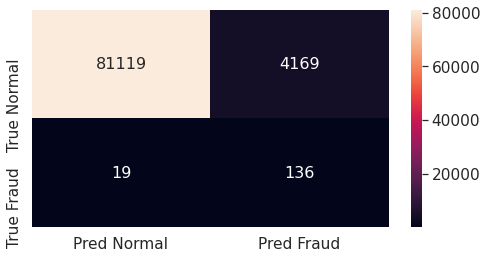

In [66]:
confusionMatrixIF  = pd.DataFrame(confusion_matrix(y_test, isof_outliers_class),
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(confusionMatrixIF, annot=True,annot_kws={"size": 16},fmt='g')# font size

# 3. Local Outlier Factor

3.1 Fitting...

Local Outlier Factor algorithm computes distances between samples to  define the neighbors for each instance. That is why all features need to be 
scaled. Features V1-V28 are already scaled as the result of PCA transformation. 
Features "Time" and "Amount" are also scaled.

In [67]:
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()


lof_df = df.copy()
lof_labels = true_labels.copy()


lof_df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
lof_df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
lof_df.drop(['Amount', 'Time'], axis = 1, inplace = True)


lof_df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972


LOF algorithm doesn't predict outliers, but identifies samples of input dataset as outliers. That is why fit_predict() method is prefered 

In [0]:
lof_train, lof_test, ylof_train, ylof_test = train_test_split(lof_df, lof_labels, test_size = 0.3)

Lof = LocalOutlierFactor(n_neighbors=50,  contamination=.1)
# 10% of instances exprected to be outliers

lof_outliers = Lof.fit_predict(lof_test)
LOF_Scores = Lof.negative_outlier_factor_

# prediction gives 1 for genuine transactions, -1 for possible frauds.
# mark outliers with 1, so their class is compatible with true_labels

lof_outliers_class = lof_outliers.copy()

for i in range(len(lof_outliers)):
  if lof_outliers[i] == 1:
    lof_outliers_class[i] = 0
  else:
    lof_outliers_class[i] = 1


3.2 Evaluation of Local Outlier Factor

In [69]:
print('Recall score for LOF:', recall_score(ylof_test, lof_outliers_class), 
      '\nPrecision score for LOF:', precision_score(ylof_test, lof_outliers_class),
      '\nAccuracy score for LOF:', accuracy_score(ylof_test, lof_outliers_class))

Recall score for LOF: 0.304635761589404 
Precision score for LOF: 0.0053832650672908135 
Accuracy score for LOF: 0.8993012885783505


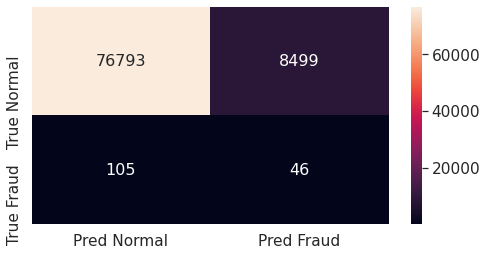

In [70]:
confusionMatrixLOF  = pd.DataFrame(confusion_matrix(ylof_test, lof_outliers_class),
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(confusionMatrixLOF, annot=True,annot_kws={"size": 16},fmt='g')

# 4. Ensemble Of Models

Train LOF using a dataset of possible outliers and inliers identified by IF, 
with ratio of outliers to all data being 1:9

In [71]:
len(isoF_outliers_values)*8

34440

4.1 Fitting...

In [0]:
LOF_df = isoF_inliers_values[0:34440]
ens_df=np.concatenate((LOF_df, isoF_outliers_values), axis = 0) 

# labels for dataset used by ensemble technique
# inliers predicted by LOF have label = 0
# outliers predictes by IF have label = 1
a = np.zeros(len(LOF_df))
b = np.ones(len(isoF_outliers_values))
ens_labels = np.concatenate((a,b), axis = 0) 


In [0]:
ens_train, ens_test, yens_train, yens_test = train_test_split(ens_df, ens_labels, test_size = 0.3)

Lof = LocalOutlierFactor(n_neighbors=30,  contamination=.1)
# 10% of instances exprected to be outliers

ens_outliers = Lof.fit_predict(ens_test)

# prediction gives 1 for genuine transactions, -1 for possible frauds.
# mark outliers with 1, so their class is compatible with true_labels

ens_outliers_class = ens_outliers.copy()

for i in range(len(ens_outliers)):
  if ens_outliers[i] == 1:
    ens_outliers_class[i] = 0
  else:
    ens_outliers_class[i] = 1


4.2 Evaluation of enseble of models

In [75]:
print('Recall score for ensemble:', recall_score(yens_test, ens_outliers_class), 
      '\nPrecision score for ensemble:', precision_score(yens_test, ens_outliers_class),
      '\nAccuracy score for ensemble:', accuracy_score(yens_test, ens_outliers_class))

Recall score for ensemble: 0.33591331269349844 
Precision score for ensemble: 0.37317282889079967 
Accuracy score for ensemble: 0.8634721266345492


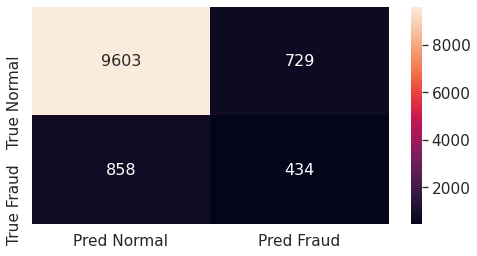

In [76]:
confusionMatrixENS  = pd.DataFrame(confusion_matrix(yens_test, ens_outliers_class),
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(confusionMatrixENS, annot=True,annot_kws={"size": 16},fmt='g')

In this dataset there are 492 transactions marked as fraudulent, 
and the previous ensemble of Isolation Forest and Local Outlier Factor 
proves that is best suited for fraud detection from credit card transactions 
since it correctly classifies 434 out of 492 fraudulent transactions.